# This notebook demonstrates basic examples of fitting, analyzing the results of a fit, and plotting the data.

In [17]:
%cd D:\Github\rf-analysis-tools
from __future__ import division, absolute_import, print_function
%matplotlib inline

import lmfit
import matplotlib.pyplot as plt
import numpy as np

from resonator.resonator import background, reflection, see

D:\Github\rf-analysis-tools


First, we make some fake data to use for the fit. The span of the frequencies shown here should be enough to reliably fit even backgrounds with more complicated structure.

In [4]:
# Background model and parameters
background_model = background.MagnitudePhase()
magnitude = 0.01
phase = -np.pi / 3

# Foreground model and parameters
foreground_model = reflection.LinearReflection()
resonance_frequency = 1e9
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000

# Create an array of measurement frequencies
linewidth = resonance_frequency * (internal_loss + coupling_loss)
frequency = np.linspace(resonance_frequency - 8 * linewidth, resonance_frequency + 8 * linewidth, 501)

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=frequency, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=frequency, resonance_frequency=resonance_frequency, internal_loss=internal_loss, coupling_loss=coupling_loss)

# The ideal data is the product of the background and foreground, and we add some noise to this.
data = bg * fg + 0.05 * magnitude * (np.random.randn(frequency.size) + 1j * np.random.randn(frequency.size)) 

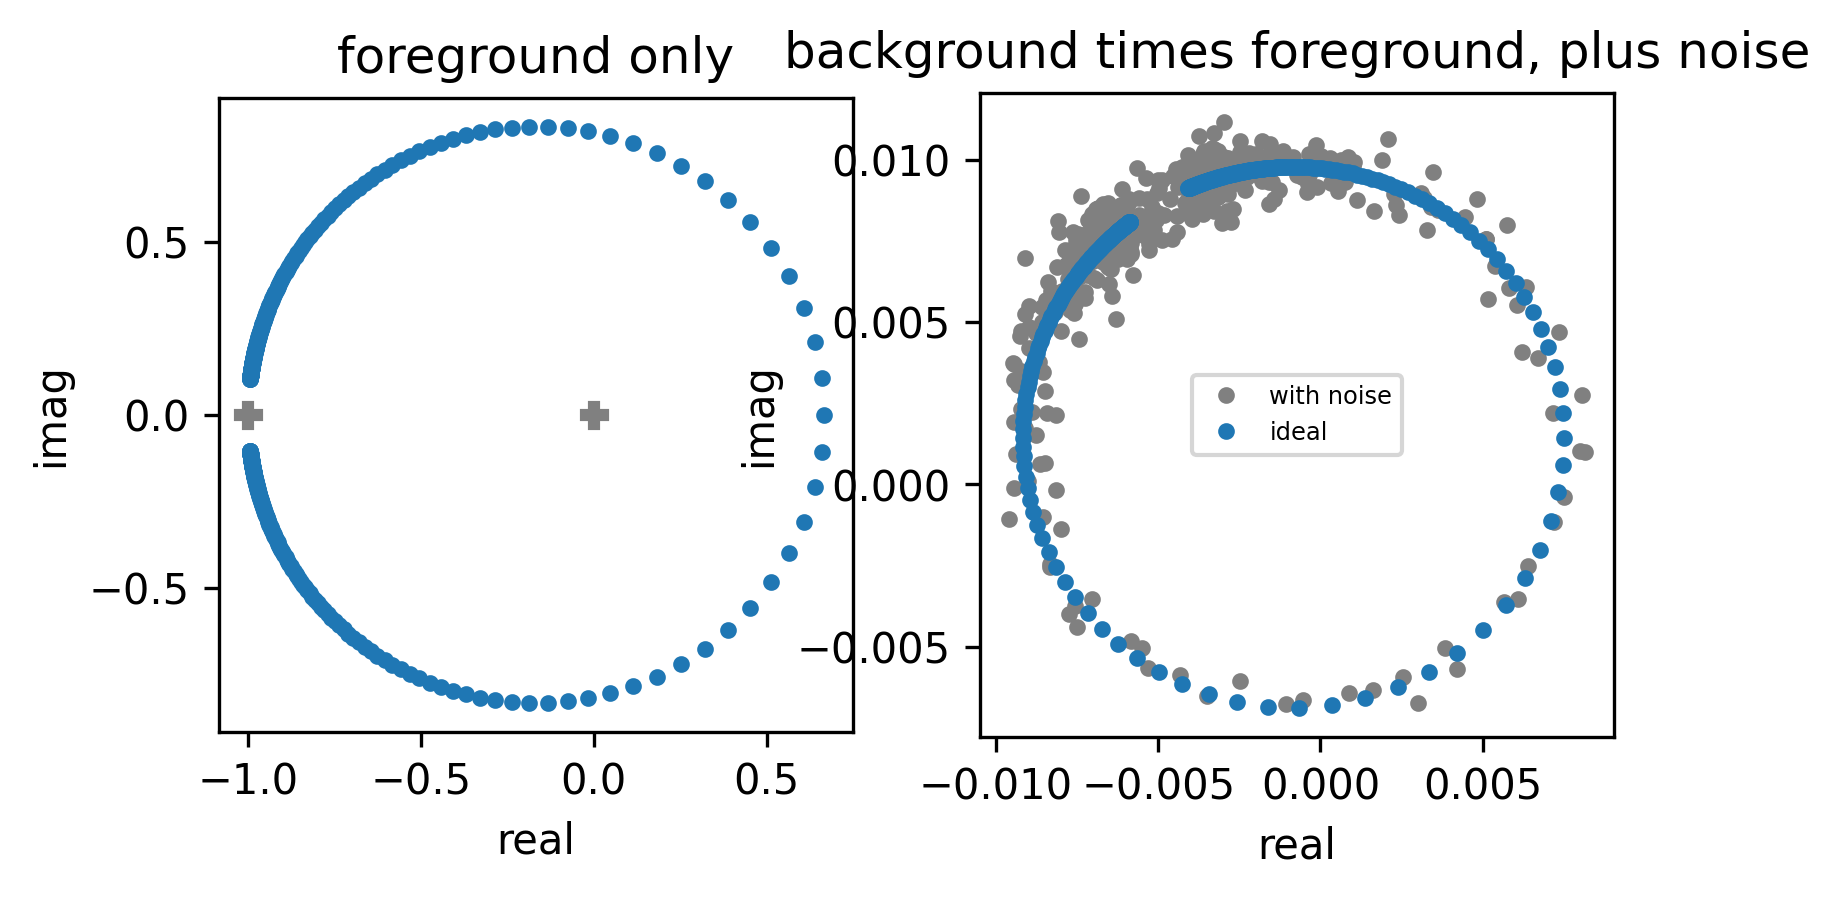

In [5]:
fig, (ax_fg, ax_bgfg) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)

ax_fg.set_aspect('equal')
ax_fg.set_xlabel('real')
ax_fg.set_ylabel('imag')
ax_fg.plot(fg.real, fg.imag, '.')
ax_fg.plot([0, -1], [0, 0], marker='P', linestyle='none', color='gray')
ax_fg.set_title('foreground only')

ax_bgfg.set_aspect('equal')
ax_bgfg.set_xlabel('real')
ax_bgfg.set_ylabel('imag')
ax_bgfg.plot(data.real, data.imag, '.', color='gray', label='with noise')
ax_bgfg.plot((bg * fg).real, (bg * fg).imag, '.', label='ideal')
ax_bgfg.legend(fontsize='xx-small')
ax_bgfg.set_title('background times foreground, plus noise');

Fit the data in one line by creating a ResonatorFitter object. This object uses the frequency and data to produce guesses for the inital parameters that will usually be close enough for the fit to converge. In this case, we use the LinearReflectionFitter, assuming that the input power is low enough that the shape of the resonance is not distorted. The `PhaseMagnitude` background model that was used to create the fake data is also the default background for this fitter, so here we do not have to specify a background.

In [6]:
r = reflection.LinearReflectionFitter(frequency=frequency, data=data)

Here, `result` is a `lmfit.model.ModelResult` object that contains all of the results of the fit. It's a good idea to look at these fit reports to see the estimates of the standard errors and the correlations between variables. Occasionally, the fit will fail to estimate the errors, and they will all be NaN.

The five model parameters (variables) are `magnitude` and `phase`, which are parameters of the background model, and `resonance_frequency`, `internal_loss`, and `coupling_loss`, which are parameters of the resonator model. The coupling and internal losses are respectively defined $\Lambda_c \equiv Q_c^{-1}$ and $\Lambda_i \equiv Q_i^{-1}$, where $Q_c$ is the coupling quality factor and $Q_i$ is the internal quality factor. (See `README.md` for an explanation of why the models use these parameters.)

In [7]:
print(r.result.fit_report())

[[Model]]
    (Model(magnitude_phase) * Model(linear_reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1002
    # variables        = 5
    chi-square         = 2.6891e-04
    reduced chi-square = 2.6972e-07
    Akaike info crit   = -15151.1329
    Bayesian info crit = -15126.5842
    R-squared          = (1.0084350755403677-0.004850070521221174j)
[[Variables]]
    magnitude:            0.01002690 +/- 2.5661e-05 (0.26%) (init = 0.009914697)
    phase:               -1.04423270 +/- 0.00255084 (0.24%) (init = -0.9425194)
    resonance_frequency:  1.0000e+09 +/- 203.654509 (0.00%) (init = 1.000001e+09)
    coupling_loss:        5.0254e-05 +/- 3.2957e-07 (0.66%) (init = 5.557369e-05)
    internal_loss:        1.0314e-05 +/- 4.1472e-07 (4.02%) (init = 1.162624e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(magnitude, internal_loss)     = +0.3687
    C(phase, resonance_frequency)   = -0.3611
    C(coupling_

The ResonatorFitter object makes all of the fit parameters and their estimated standard errors available for attribute access. Since quality factors and energy decay rates are often used instead of the inverse quality factors, the former are available too. See `base.ResonatorFitter` or use `print(dir(r))` to see all of the available quantities.

In [8]:
print("The internal quality factor is Q_i = {:.0f}".format(r.Q_i))
print("The total quality factor is Q_t = {:.0f}".format(r.Q_t))
print("The standard error of the resonance frequency is: {:.0f} Hz".format(r.f_r_error))
print("The total energy decay rate is 2 pi f_r / Q_t = {:.0f} s^-1".format(r.total_energy_decay_rate))

The internal quality factor is Q_i = 96956
The total quality factor is Q_t = 16510
The standard error of the resonance frequency is: 204 Hz
The total energy decay rate is 2 pi f_r / Q_t = 380557 s^-1


Since we know the true parameter values, we can check that the fit parameters are mostly within one or two estimated standard errors.

In [9]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("resonance_frequency: {:.2f}".format(abs(r.resonance_frequency - resonance_frequency) / r.resonance_frequency_error))
print("coupling_loss: {:.2f}".format(abs(r.coupling_loss - coupling_loss) / r.coupling_loss_error))
print("internal_loss: {:.2f}".format(abs(r.internal_loss - internal_loss) / r.internal_loss_error))
print("magnitude: {:.2f}".format(abs(r.magnitude - magnitude) / r.magnitude_error))
print("phase: {:.2f}".format(abs(r.phase - phase) / r.phase_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
resonance_frequency: 1.01
coupling_loss: 0.77
internal_loss: 0.76
magnitude: 1.05
phase: 1.16


The `see.py` module contains functions that quickly create nice plots of the data. The line is the model evaluated at lots of points, and the larger dot in the same color is the model at the resonance frequency.

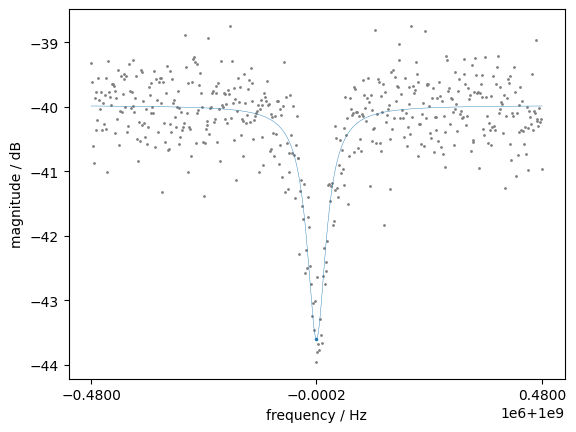

In [10]:
fig, ax = see.magnitude_vs_frequency(r)

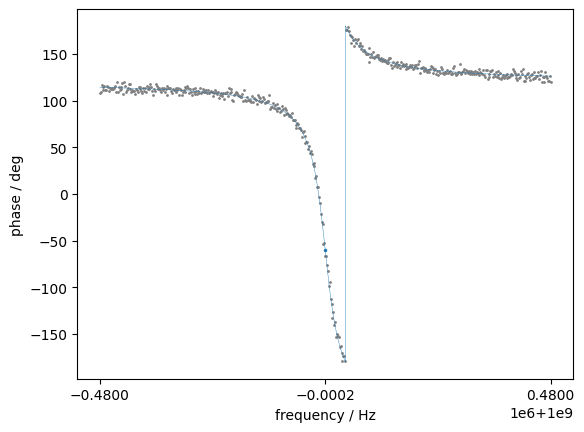

In [11]:
fig, ax = see.phase_vs_frequency(r)

If the `normalize` keyword is true, the data and model values are divided by the background model in order to normalize them to the resonator plane. Here, the data and model approach -1 + 0j far from resonance because of the reflection. The data points are fairly equally distributed around the model, which forms a circle in the complex plane, and this is generally a sign that the fit is good and that the background model sufficiently describes the background.

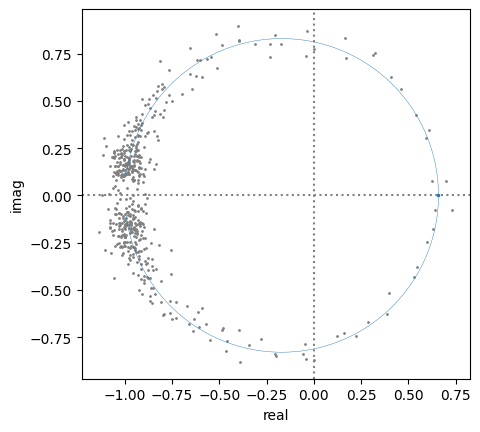

In [12]:
fig, ax = see.real_and_imaginary(r, normalize=True)

The `triptych` function used here plots the data and fits three different ways. The initial fit is not plotted by default, but it can be useful for debugging if a fit fails to converge to reasonable values. Often, the problem is simply that the initial values are too far from the true values. See the notebook `advanced.ipynb` for some methods for succesfully fitting in this case.

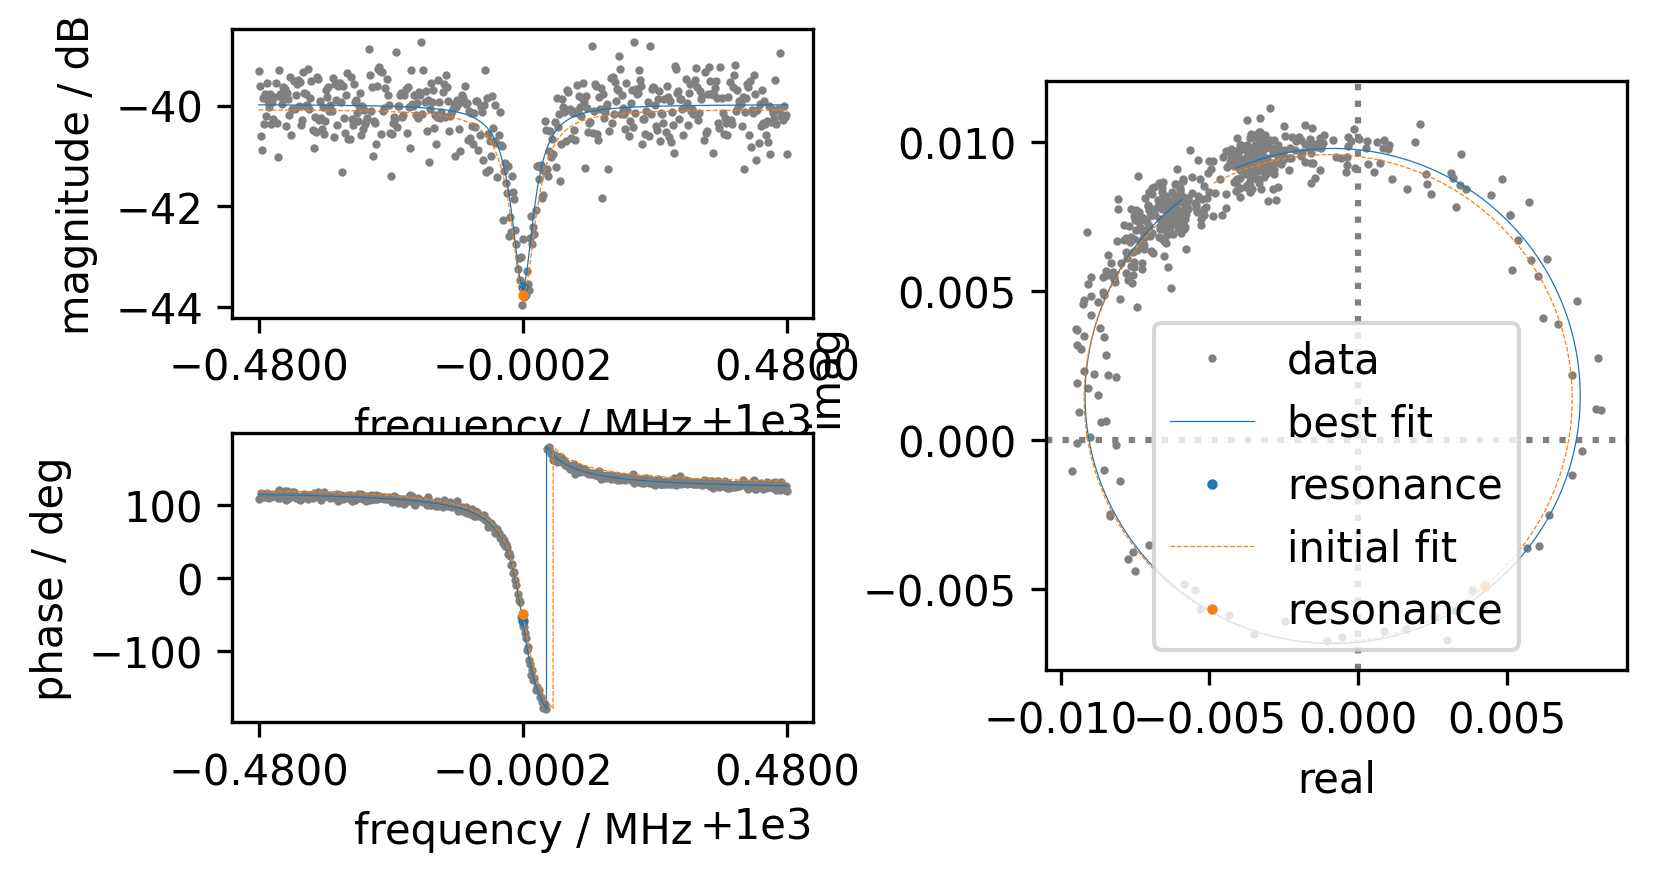

In [16]:
fig, (ax_magnitude, ax_phase, ax_complex) = see.triptych(resonator=r, plot_initial=True, frequency_scale=1e-6, figure_settings={'figsize': (6, 3), 'dpi': 300})
ax_complex.legend();